IDEA: make a uCal "lite" that just gives a low-order polynomial as a "guess" abs cal (doesn't try to fit the primary beam)
IDEA: uCal ultralite which just uses exactly redudnant bl/chan pairs in u with the goal of informing some low order polynomial across the band

IDEA: perhaps a no-beam model is good enough if then we run a fringe-rate filter to get a time-averaged beam (assuming that residuals are sky-like because they are due to beam errors)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import capo.omni as omni, capo.zsa as zsa, capo.arp as arp
import scipy
import scipy.constants
import aipy as a
import optparse, sys, os
import capo
import capo.uCal as uc
uc = reload(capo.uCal)
%matplotlib notebook 
%load_ext line_profiler

# Option Parsing

In [2]:
sys.argv[1:] = ['./VisibilitySimulator/SimulatedVisibilities/simple_SevenSources_VariedSpIndex_achromaticBeam.2456679.35658.xx.npz', 
                '-C', 'psa6622_v003', 
                '-p', 'xx', 
                '--verbose', 
                '--overwrite', 
                '--spindex', '.55', 
                '--flagchan', '-1', 
                '--desiredDeltau', '.25', 
                '--beamfullrange', '5', 
                '--maxiter', '50', 
                '--beamwidthorder', '0', 
                '--skyfreqorder', '2',
#                '--skyfreqbasis', 'SkyFreqBasis.npy',
                '--umin', '25', 
                '--umax', '130']

In [3]:
o = optparse.OptionParser()
o.set_usage('run_uCal.py [omnical .npz file or files] -C [calfile] -p [polarization] [other options]')
a.scripting.add_standard_options(o, cal=True, pol=True)
o.add_option('--overwrite', action='store_true',
    help='Overwrites previous result with the same filename.')
o.add_option('--verbose', action='store_true',
    help='Makes uCal verbose.')

array_opts = optparse.OptionGroup(o, 'Array Options', 'These options control specify parameters related to the array.')
array_opts.add_option('--sfreq', type='float', default=0.1,
    help='Starting frequency in GHz. Default is 0.1.')
array_opts.add_option('--sdf', type='float', default=0.1/203,
    help='Frequency channel width in GHz. Default is 0.1/203.')
array_opts.add_option('--nchan', type='int', default=203,
    help='Number of frequency channels. Default is 203.')
array_opts.add_option('--flagchan', type='string', default='14,15,16,17,18,19,20,21,174,175,176,177,178,179,180,181,182,183,184,185,186',
    help='Channels to always remove. Defaults are 14,15,16,17,18,19,20,21,174,175,176,177,178,179,180,181,182,183,184,185,186.')
o.add_option_group(array_opts)

uCal_opts = optparse.OptionGroup(o, 'uCal Runtime Options', 'These control how uCal is run.')
uCal_opts.add_option('--prefix', type='string', default='.',
    help='Inserts a string prefix before the saved files. Default is just "."')
uCal_opts.add_option('--umin', type='float', default=0.0, 
    help='Minimum value of u (in wavelengths) for visibilities. Default is 0.0')
uCal_opts.add_option('--umax', type='float', default=1000.0, 
    help='Maximum value of u (in wavelengths) for visibilities. Default is 10000.0')
uCal_opts.add_option('--maxiter', type='int', default=50, 
    help='Maximum number of allowed iterations of lincal. Default is 50.')
uCal_opts.add_option('--spindex', type='float', default=.55,
    help='Foreground spectral index used for final bandpass estimate (for Jy, not K). Default is .55.')
uCal_opts.add_option('-F', '--flagsuffix', type='string', default=None,
    help='Flags using xrfi flag files with a suffix that replaces the ".npz" at the end of the omnical data files.')
o.add_option_group(uCal_opts)

param_opts = optparse.OptionGroup(o, 'uCal Parameter Options', 'These set the parmeterization of the uCal model.')
param_opts.add_option('--desiredDeltau', type='float', default=0.25, 
    help='Approximate discretization of the Fourier-transformed sky. Default is 0.25 wavelengths.')
param_opts.add_option('--skyfreqorder', type='int', default=1, 
    help='Order of basis function for the underlying sky as a funciton of frequency. Default is 1.')
param_opts.add_option('--skyfreqbasis', type='string', default=None, 
    help='Basis functions for sky frequency dependence. Default is polynomials in log(freq).')
param_opts.add_option('--beamFWHMguess', type='float', default=1.0, 
    help='Initial Gaussian Fourier-transformed primary beam FWMH guess (in wavelengths). Default is 1.0.')
param_opts.add_option('--beamwidthorder', type='int', default=6, 
    help='Polynomial order of the beam width dependence on freq. Default is 6.')
param_opts.add_option('--beamfullrange', type='float', default=10.0, 
    help='Outside a region of this width, the primary beam is taken to be 0. Default is 10.0 wavelengths.')
o.add_option_group(param_opts)

if len(sys.argv)==1: #for internal testing only.
    print "No arguments provided. Exiting..."
    sys.exit()
    #TODO: UPDATE THIS!!!
else:
    opts,args = o.parse_args(sys.argv[1:])
    dataFiles = args
    pol, verbose, overwrite = opts.pol, opts.verbose, opts.overwrite
    flagSuffix = opts.flagsuffix
    spectralIndex = opts.spindex
    freqs = np.arange(opts.sfreq, opts.sfreq+opts.sdf*opts.nchan, opts.sdf)
    chans = range(len(freqs))
    calFile = opts.cal
    uMin, uMax = opts.umin, opts.umax
    desiredDeltau = opts.desiredDeltau
    skyFreqOrder, skyFreqBasisFile = opts.skyfreqorder, opts.skyfreqbasis
    beamFWHMguess, beamWidthOrder, beamFullRange = opts.beamFWHMguess, opts.beamwidthorder, opts.beamfullrange
    manualChannelFlags = [int(chan) for chan in opts.flagchan.split(',')]
    #manualChannelFlags = range(0,30) + range(170,210) # flags to fix the screwed up PAPER beam model in the calfile
    outfilePrefix = opts.prefix
    maxIterations = opts.maxiter

# PAPER-128 Setup Functions

In [4]:
def getBaselines(freqs, intSeps, exampleDataFile, calFile='psa6622_v003'):
    aa = a.cal.get_aa(calFile, freqs)
    blstr, _, bl2sep = zsa.grid2ij(aa.ant_layout)
    m, _, mdl,_= omni.from_npz(exampleDataFile)
    bls = [(0,i) for i in intSeps]
    for ij in mdl['xx'].keys():
        bl = a.miriad.ij2bl(ij[0],ij[1]) 
        try:
            s = tuple(map(int,bl2sep[bl].split(',')))
        except(KeyError):
            continue
        if s in bls and s[0] == 0:
            bls[s[-1]-1] = ij
    return bls

def blRedundancyDictFromCalFile(calFile = 'psa6622_v003', verbose = False):
    """ Uses Omnical to figure out the number of redundant baselines for a given separation (as demarkated by a representative baseline tuple). 
    Returns redundancyDict and also saves it as an instance variable."""
    aa = a.cal.get_aa(calFile,np.array([.15]))
    if verbose: print 'Now generating baseline redundancy dictionary from calfile...'
    ex_ants = [5,7,8,15,16,17,24,26,27,28,29,37,38,46,48,50,51,53,55,63,68,69,72,74,76,77,82,83,84,85,92,107,110]
    info = capo.omni.aa_to_info(aa, pols=['x'], ex_ants=ex_ants)
    reds = info.get_reds()
    redundancyDict = {}
    #This is overkill...it maps all baselines to their redundancy, not just the ones we need. But that's fine.
    for red in reds:
        for bl in red: redundancyDict[bl] = len(red)
    return redundancyDict

#TODO: this functionality needs to be tested. It can probably be simplified
def loadFlags(dataFile, flagSuffix):
    """This function loads flags from xrfi and flags channels completely that are flagged more than the threshold fraction of the time"""
    if flagSuffix is None: return None
    flags = []
    flag = np.load(dataFile.replace('.npz', flagSuffix))
    for t in range(len(flag.keys())-1): flags.append(flag[str(t)])
    return np.asarray(flags)

def loadVisibilitiesAndSamples(dataFile, pol, blList, redundancyDict, flags):
    """Loads visibilities and samples from an omnical npz. Applies flags."""
    data, samples = {}, {}
    jds, lsts = [], []
    conjugate = [(0,101), (0,62), (0,100), (0,97), (12,43), (57,64)]
    if verbose: print 'Reading %s'%dataFile
    meta,_,mdl,_ = omni.from_npz(dataFile)
    jd = meta['jds']
    lst = meta['lsts']
    jds.append(jd)
    lsts.append(lst)
    for b in bls:
        if b in conjugate: _d = np.conj(mdl[pol][b])
        else: _d = mdl[pol][b]
        if b not in data.keys(): data[b] = _d
        else: data[b] = np.concatenate((data[b],_d), axis=0)
        samples[b] = redundancyDict[b] * np.ones(data[b].shape)
        samples[b][data[b]==0] = 0
    if flags is not None:
        for b in bls: data[b][flags==1] = 0 #apply flags
        for b in bls: samples[b][flags==1] = 0 #apply flags
    return data, samples

In [5]:
intSeps = np.arange(1,16) #* 15m  = baseline lengths
dx = 15.0 / scipy.constants.c * 1e9
chan2FreqDict = {chan: freqs[chan] for chan in chans}
separations = dx*intSeps
if calFile is None: calFile = 'psa6622_v003'
bls = getBaselines(freqs, intSeps, dataFiles[0], calFile=calFile)#[2:]
bl2SepDict = {bl: np.asarray([sep,0.0]) for bl,sep in zip(bls,separations)}
redundancyDict = blRedundancyDictFromCalFile(calFile=calFile)
chans = range(len(freqs))

# uCal Functionality

In [7]:
def prewhitenDataWithPowerLaw(data, freqs, spectralIndex):
    for bl in data.keys(): data[bl] *= np.array(freqs)**spectralIndex

In [8]:
def uCalSetup(data, timeIndex):
    """Sets up uCal object for a given integration with data, flagged channels, etc."""
    uCal = uc.uCalibrator(verbose=verbose, beamFWHMguess=beamFWHMguess, beamFullRange=beamFullRange, 
                          beamWidthOrder=beamWidthOrder, dampingFactor = 1.0)
    uCal.setupBaselineChannelPairs(freqs, bls, chan2FreqDict, bl2SepDict, redundancyDict)
    uCal.loadData(data, timeIndex)
    uCal.flagChans(flaggedChans=manualChannelFlags)
    uCal.setupSkyFreqBasis(skyFreqOrder, skyFreqBasisFile)
    uCal.defineuSampling(desiredDeltau, uMin, uMax, beamFullRange)
    return uCal

In [9]:
#TODO: investigate whether the treshold matters
def performuCal(uCal, maxIterations=50, thresh=1e-5):
    """Performs logcal and then iterates lincal until convergence is reached or too many iterations have passed."""
    if verbose: print 'Now performing logcal...'
    betas, Sigmas = uCal.performLogcal()
    noiseVariance = uCal.generateNoiseVariance(betas)
    noiseVariance = np.ones(len(noiseVariance)); print 'noiseVariance set to identity'
    
    #return betas, Sigmas, noiseVariance
    errors = uCal.computeModelsAndErrors([uCal.bandpassFunc,uCal.uIntegralFunc], [betas, Sigmas])
    print 'Chi^2 after logcal =', np.average(np.abs(errors)**2 / noiseVariance)

    # uCal.useLogCalResultsForNLCG(betas, Sigmas)
    prevBetas = np.array(betas)
    if verbose: print 'Now performing lincal...'
    for iteration in range(maxIterations): 
        uCal.uIntegralPrecomputation(Sigmas)
        print 'beamWidth:', np.dot(Sigmas[uCal.beamWidthIndices], [(.145/.145)**n for n in range(uCal.beamWidthOrder+1)])
        (betas, Sigmas), chiSqPerDoF = uCal.generalizedLincalIteration([uCal.bandpassFunc,uCal.uIntegralFunc], [betas, Sigmas], noiseVariance, alpha=1)
        
        print 'dampingFactor:', uCal.dampingFactor
        betas, Sigmas = uCal.renormalize(None, [betas, Sigmas], absMeanGoal = uCal.meanAbsVis)
        #betas, Sigmas = uCal.renormalize(None, [betas, Sigmas], absMeanGoal = 1.0)

        if verbose: print '    Iteration ' + str(iteration+1) + ') chi^2/dof = ' + str(chiSqPerDoF)

        #Decide whether to break
        renormalizedBetas = betas / np.mean(np.abs(betas)) * np.exp(-1.0j * np.mean(np.angle(betas)))
        renormalizedOldBetas = prevBetas / np.mean(np.abs(prevBetas)) * np.exp(-1.0j * np.mean(np.angle(prevBetas)))
        print '                               change in betas: ', np.linalg.norm(renormalizedBetas - renormalizedOldBetas) / np.linalg.norm(renormalizedBetas), '\n'
        if np.linalg.norm(renormalizedBetas - renormalizedOldBetas) / np.linalg.norm(renormalizedBetas) < thresh: break


        prevBetas = np.array(betas)
        #noiseVariance = uCal.generateNoiseVariance(betas)
        #noiseVariance = uCal.renormalizeNoise([uCal.bandpassFunc,uCal.uIntegralFunc], [betas, Sigmas], noiseVariance)
    betas, Sigmas = uCal.renormalize(None, [betas, Sigmas], absMeanGoal = 1.0)
    return betas, Sigmas, noiseVariance

In [10]:
def summarizeResults(freqs, spectralIndex, uCals, allBetas, allSigmas, noiseVariances):
    """This function computes the relevant quantities for plotting or combining with future results."""
    allBandpasses = np.zeros((len(allBetas),len(freqs)),dtype=complex)
    for bandpass, beta, uCal in zip(allBandpasses, allBetas, uCals): bandpass[uCal.chans] = beta.values()
    for bandpass in allBandpasses: bandpass *= freqs**spectralIndex
    meanBandpass = np.mean(np.ma.masked_equal(allBandpasses,0),axis=0).data
    stdBandpass = np.std(np.abs(np.ma.masked_invalid(np.ma.masked_equal(allBandpasses,0))),axis=0).data
    unflaggedChans = [sorted(beta.keys()) for beta in allBetas]
    
    errorsByChan = {chan: [] for chan in range(len(freqs))}
    channelRMSs = []
    for uCal,noiseVariance in zip(uCals,noiseVariances):
        errorsByChanHere = {chan: [] for chan in range(len(freqs))}
        for ((bl,chan),entry),var in zip(uCal.blChanPairs.items(), noiseVariance):
            errorsByChan[chan].append(np.abs(entry['vis']-entry['model'])**2 / var)
            errorsByChanHere[chan].append(np.abs(entry['vis']-entry['model'])**2 / var)
        channelRMSs.append(np.asarray([np.mean(errorsByChanHere[chan])**.5 for chan in range(len(freqs))]))
    overallChannelRMS = np.asarray([np.mean(errorsByChan[chan])**.5 for chan in range(len(freqs))])
    return allBandpasses, meanBandpass, stdBandpass, unflaggedChans, channelRMSs, overallChannelRMS

# Bandpass Functions

In [11]:
def applyArtificialBandpass(data, appliedBandpass):
    for bl in data.keys():
        data[bl] *= appliedBandpass

#appliedBandpass = np.ones(len(chans))
#appliedBandpass = [np.sin(freqs[chan]/.01)+2 for chan in chans]
#appliedBandpass = [np.exp(1.0j * freqs[chan]/.01) + 3 for chan in chans]
appliedBandpass = [np.exp(-(freqs[chan]-.15)**2/(2*.025**2)) * (np.exp(1.0j * freqs[chan]/.001) + 10) for chan in chans]
#appliedBandpass = np.random.rand(len(chans)) + np.random.rand(len(chans))*1.0j + 3.0

appliedBandpass = np.asarray(appliedBandpass) / np.mean(np.abs(appliedBandpass)) * np.exp(-1.0j * np.mean(np.angle(appliedBandpass)))


# Run uCal

In [12]:
%cd /Users/jsdillon/Desktop/capo
!python setup.py install >/dev/null
%cd /Users/jsdillon/Desktop/capo/jsd/uCal
uc = reload(capo.uCal)

for dataFile in dataFiles:
    resultsFile = dataFile.replace('.npz', outfilePrefix + 'uCalResults.npz')
    if os.path.exists(resultsFile) and not overwrite:
        print '\n    ' + resultsFile + ' exists...skipping.\n'
        continue
    flags = loadFlags(dataFile, flagSuffix)
    data, samples = loadVisibilitiesAndSamples(dataFile, pol, bls, redundancyDict, flags)
    prewhitenDataWithPowerLaw(data, freqs, spectralIndex)
    applyArtificialBandpass(data, appliedBandpass)
    uCals, allBetas, allSigmas, noiseVariances = [], [], [], []
    for t in [0]:
#     #for t in range(len(data[bls[0]])):
        if verbose: print '\nNow analyzing timeslice ' + str(t) + ' of ' + dataFile
        uCal = uCalSetup(data, timeIndex=t)
        #%lprun -f uCal.uIntegralFunc performuCal(uCal, thresh=1e-8, maxIterations=50)
        betas, Sigmas, noiseVariance = performuCal(uCal, thresh=1e-8, maxIterations=50)
        
#         uCals.append(uCal)
#         allBetas.append(betas)
#         allSigmas.append(Sigmas)
#         noiseVariances.append(noiseVariance)
# #TODO: turn back on!!!
#     allBP, meanBP, stdBP, unflagged, RMSs, RMS = summarizeResults(freqs, spectralIndex, uCals, allBetas, allSigmas, noiseVariances) 
#     uc.to_npz(resultsFile, [dataFile], allBP, meanBP, stdBP, unflagged, RMSs, RMS)

/Users/jsdillon/Desktop/capo
/Users/jsdillon/Desktop/capo/jsd/uCal
Reading ./VisibilitySimulator/SimulatedVisibilities/simple_SevenSources_VariedSpIndex_achromaticBeam.2456679.35658.xx.npz

Now analyzing timeslice 0 of ./VisibilitySimulator/SimulatedVisibilities/simple_SevenSources_VariedSpIndex_achromaticBeam.2456679.35658.xx.npz
Examining 3045 visibilities from 203 channels...
    After flagging, 3045 visibilities from 203 channels remain.
    After cuts based on u, 2369 visibilities from 203 channels remain.
    With 0.246475932412 wavelength spacing, there are 446 coarse u bins.
Now performing logcal...
For lincal, we are trying to fit 1295 u sample parameters.
Now initializing the frequency-dependent primary beam kernel by fitting...
noiseVariance set to identity
Chi^2 after logcal = 3948.07190044
Now performing lincal...
beamWidth: (0.04882991685+0j)
        CONDITION NUMBER: 7.87353605443e+17
2.0 47450.4142277 43504.063174 0.0
4.0 20029.9275509 16083.5764972 0.0
8.0 6250.3286716

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 446, 11, 447, 871, 12, 448, 872, 13, 449, 873, 14, 450, 874, 15, 451, 875, 16, 452, 876, 17, 453, 877, 18, 454, 878, 19, 455, 879, 20, 456, 880]
42
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 11, 11, 11, 12, 12, 12, 13, 13, 13, 14, 14, 14, 15, 15, 15, 16, 16, 16, 17, 17, 17, 18, 18, 18, 19, 19, 19, 20, 20, 20]


<IPython.core.display.Javascript object>


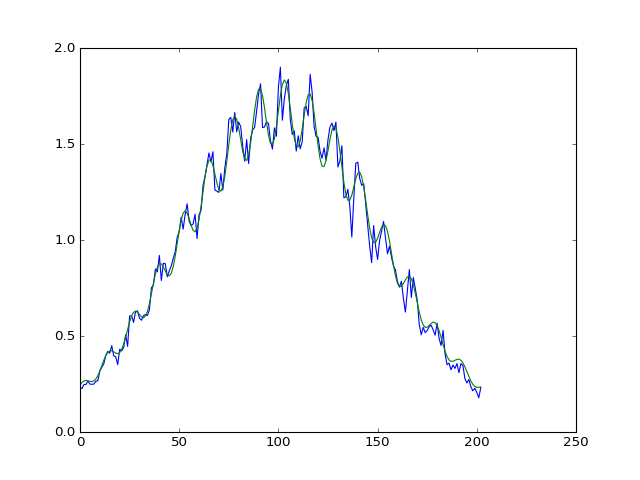

In [14]:
print uCal.blChanPairs.values()[1415]['uParamIndicesHere']
print len(uCal.blChanPairs.values()[1415]['uParamOrders'])
print uCal.blChanPairs.values()[1415]['uParamBeamIndices']


#print uCal.blChanPairs.values()[1415]['coarseSkyIndices'][1,:]
#print uCal.blChanPairs.values()[1415]['coarseSkyBasisFuncs']


test = [orderIndices for orderIndices in uCal.blChanPairs.values()[1415]['coarseSkyIndices']]
#print [Sigmas[orderIndices] for orderIndices in uCal.blChanPairs.values()[1415]['coarseSkyIndices']]
#print test[1]



#uCal.uIntegralPrecomputation(Sigmas)
#test = uCal.fineDu*np.arange(-uCal.beamFineBins/2.0, uCal.beamFineBins/2.0)
#print uCal.beamWidthDict

#print uCal.fineDeltausHere[np.abs(uCal.fineDeltaus) < 1e-10]

plt.figure(122322)
#plt.plot(uCal.coarseuBins, [uCal.uOrders[u] for u in uCal.coarseuBins])
#plt.plot(betas,'.-')
#plt.plot(Sigmas,'.')
#plt.plot(uCal.gaussBeamDict[freqs[0]])
#plt.plot(uCal.skyFreqBasis[:,2])

#print Sigmas[uCal.blChanPairs.values()[0]['coarseSkyIndices']].shape

#allu = [entry['u'] for entry in uCal.blChanPairs.values()]
#print np.argmin(allu)
#plt.plot(uCal.coarseDeltaus, np.real(uCal.coarseSky),'.-',ms=15)
#plt.plot(uCal.fineDeltaus, np.real(uCal.interpolatedSky), '.-')
#plt.plot(uCal.beamWidths)


plt.plot(betas)
plt.plot(appliedBandpass)
#plt.plot(uCal.FourierDownsample(uCal.FourierInterpolate(np.arange(21), uCal.padding), uCal.padding))


In [47]:
print uCal.uIntegralFunc(uCal.blChanPairs.values()[0], Sigmas, derivative=True)[0][-1]
Sigmas2 = np.copy(Sigmas)
epp = (1.0+1.0j)/10
Sigmas2[446] += epp
#print Sigmas2[262]
print (uCal.uIntegralFunc(uCal.blChanPairs.values()[0], Sigmas2) - uCal.uIntegralFunc(uCal.blChanPairs.values()[0], Sigmas))/epp

(-1809.80007749+3583.83267832j)
447
0j


# Plotting

In [15]:
chans = uCal.chans

appliedBandpass = appliedBandpass[chans]

# #%% Plot bandpass
# plt.figure(1); plt.clf()
for uCal,betas,Sigmas in zip(uCals, allBetas, allSigmas):
    #for chan in uCal.chans: betas[uCal.chanIndices[chan]] *= freqs[chan]**spectralIndex
    bandpass = uCal.renormalize(None, [betas, Sigmas], absMeanGoal = 1.0)[0]
    plt.plot(chans, (np.abs(bandpass - appliedBandpass))/np.abs(appliedBandpass))
#plt.errorbar(chans,np.abs(meanBandpass)[allUnflaggedChans],yerr=np.abs(stdBandpass)[allUnflaggedChans], fmt='k')
# plt.xlabel('channel'); plt.ylabel('abs(Bandpass) relative error')

if True:


    allvis = np.asarray([value['vis'] for value in uCal.blChanPairs.values()])
    allmodel = np.asarray([value['model'] for value in uCal.blChanPairs.values()])
    allu = np.asarray([value['u'] for value in uCal.blChanPairs.values()])
    allb = np.asarray([value['u']/freqs[chan] for (bl,chan),value in uCal.blChanPairs.items()])
    allfreq = np.asarray([freqs[chan] for (bl,chan),value in uCal.blChanPairs.items()])
    allNearestSampleIndices = np.asarray([int(np.round((u - uCal.uSamples[0]  + 1e-10)/uCal.deltau)) for u in allu])
    allNearestSamples = np.asarray([uCal.uSamples[index] for index in allNearestSampleIndices])
    allDeltaus = allu - allNearestSamples

    plt.figure(2); plt.clf()
    plt.plot(allu, np.real(allvis), '.')
    for fBin in [0, 100, 200]:
        usToPlot = np.arange(np.min(allu)-beamFullRange/2.0, np.max(allu)+beamFullRange/2.0, .01)
        #uModel = [uCal.uIntegralFunc(None, Sigmas, specify={'u':u, 'freq':.145}) for u in usToPlot]
        uModel = [betas[fBin]*uCal.uIntegralFunc(None, Sigmas, specify={'u':u, 'freq':freqs[fBin]}) for u in usToPlot]
        plt.plot(usToPlot, np.real(uModel),'-')

IndexError: list index out of range

In [ ]:
plt.figure(3, figsize=(16,8)); plt.clf()
plt.subplot(211)
plt.plot(chans, np.real(bandpass), 'b.')
plt.plot(chans, np.real(appliedBandpass),'r')
plt.plot(chans, np.imag(bandpass), 'g.')
plt.plot(chans, np.imag(appliedBandpass),'k')
plt.legend(['Real(Solved Bandpass)', 'Real(Applied Bandpass)', 'Imag(Solved Bandpass)', 'Imag(Applied Bandpass)'])
plt.xlabel('chan'); plt.ylabel('Bandpass Component')

plt.subplot(212)
toFit = np.abs(bandpass) / np.abs(appliedBandpass)
plt.semilogy(chans, toFit, '.')
maxPolyOrder = 8
for order in range(maxPolyOrder+1):
    fit = np.polyfit(freqs[chans], toFit, order)
    fitResult = np.polyval(fit, freqs[chans])
    plt.semilogy(chans, np.abs(fitResult - toFit), '.')

plt.legend(['Abs(Solved Bandpass / Applied)'] + ['Abs(Order ' + str(order) + ' Polynomial Error)' for order in range(maxPolyOrder+1)], fontsize=8)


In [ ]:
test = {i: i**2 for i in range(10)}
print test.values()
test[4] = 15
print test.values()
test[3.5] = 3.5**2
print test.values()